# 导入必要的工具包

In [14]:
#sk里面的实现
from xgboost import XGBClassifier
#单独实现
import xgboost as xgb
#读取文件的类
import pandas as pd
#矩阵的类
import numpy as np
#交叉验证的类
from sklearn.model_selection import GridSearchCV
#分层采样的类
from sklearn.model_selection import StratifiedKFold
#评分标准 log似然损失
from sklearn.metrics import log_loss
#画图的类
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

# 读取数据

In [15]:
#读取csv文件
train = pd.read_csv("RentListingInquries_FE_train.csv")
#显示头5行信息
train.head()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,1.5,3,3000,1200.0,750.000000,-1.5,4.5,2016,6,24,...,0,0,0,0,0,0,0,0,0,1
1,1.0,2,5465,2732.5,1821.666667,-1.0,3.0,2016,6,12,...,0,0,0,0,0,0,0,0,0,2
2,1.0,1,2850,1425.0,1425.000000,0.0,2.0,2016,4,17,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1,3275,1637.5,1637.500000,0.0,2.0,2016,4,18,...,0,0,0,0,0,0,0,0,0,2
4,1.0,4,3350,1675.0,670.000000,-3.0,5.0,2016,4,28,...,0,0,1,0,0,0,0,0,0,2


In [16]:
#查看详细信息
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49352 entries, 0 to 49351
Columns: 228 entries, bathrooms to interest_level
dtypes: float64(9), int64(219)
memory usage: 85.8 MB


In [17]:
#查看是否有空值
train.isnull()

,bathrooms,bedrooms,price,price_bathrooms,price_bedrooms,room_diff,room_num,Year,Month,Day,...,walk,walls,war,washer,water,wheelchair,wifi,windows,work,interest_level
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


没有发现空值的情况

# 查看样本分布是否均匀

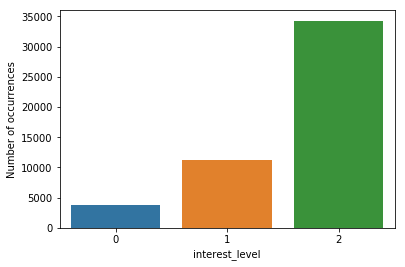

In [18]:
#拿出y轴的结果画图
sns.countplot(train.interest_level);
#设置x轴的名字
pyplot.xlabel('interest_level');
#设置y轴的名字
pyplot.ylabel('Number of occurrences');

不够均匀，非常感兴趣的占大多数

# 拿到训练集数据的X核y轴

In [20]:
#拿到y轴的值
y_train = train['interest_level']
#从训练集中删除y轴interest_level
train = train.drop(["interest_level"], axis=1)
#把训练集变为矩阵
X_train = np.array(train)


# 因为数据量不均匀  要按比例采样

In [21]:
#实例化分层采样的类
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)
#n_splits=5 切割5次
#shuffle=True  是否进行落地计算
#random_state=3 随机的次数

默认参数，学习率(learning_rate)为0.1，比较大，观察弱分类数目的大致范围
（采用默认参数配置，看看模型是过拟合还是欠拟合）

In [22]:
#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
#定义一个方法
def modelfit(alg, X_train, y_train, cv_folds=None, early_stopping_rounds=10):
    #alg  XGBoost模型
    #X_train X轴的训练数据
    #y_train y轴的训练集
    #cv_folds  分层采样的类
    #early_stopping_rounds=10  有多少组相同的数据就结束
    
    #从模型中拿到所有的值
    xgb_param = alg.get_xgb_params()
    #给这个类赋值
    xgb_param['num_class'] = 9
    
    #直接调用xgboost，而非sklarn的wrapper类
    #调用xgboost来转化数据  变为稀疏向量
    xgtrain = xgb.DMatrix(X_train, label = y_train)
    #X_train  x轴的数据
    #label = y_train  结果集为y轴的数据
    
    #调用内部的交叉验证
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], folds =cv_folds,
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
    #xgb_param  从模型中拿到的值
    #xgtrain    把训练数据变为稀疏向量的值
    #num_boost_round=alg.get_params()['n_estimators']   迭代的计算次数    从模型中拿出 弱分类数目当做迭代次数
    #folds =cv_folds  分层采样
    # metrics='mlogloss'  评价函数
    #early_stopping_rounds=early_stopping_rounds  有多少组相同的数据就结束
      
    #输出为csv文件 
    cvresult.to_csv('a_nestimators.csv', index_label = 'n_estimators')
    #index_label = 'n_estimators'  结果的索引是弱分类器
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    
    # 采用交叉验证得到的最佳参数n_estimators，训练模型
    alg.set_params(n_estimators = n_estimators)
    #训练
    alg.fit(X_train, y_train, eval_metric='mlogloss')
    #X_train  x轴的训练集
    #y_train  y轴训练集的结果

In [23]:
#实例化XGBoost模型
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,  #数值大没关系，cv会自动返回合适的n_estimators
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.3,
        colsample_bytree=0.8,
        colsample_bylevel=0.7,
        objective= 'multi:softprob',
        seed=3)

#learning_rate =0.1  学习率
#n_estimators=1000 弱分类器的数目
#max_depth=5  树的最大深度
#min_child_weight=1 叶子节点需要的最小权重
#gamma=0 节点分裂所需的最小损失函数下降值
#subsample=0.3 样本采样比例
#colsample_bytree=0.8  每棵树所用的特征比例
#colsample_bylevel=0.7 树在每层每个分裂的所用特征比例
#objective= 'multi:softprob'  待优化的目标参数  多分类问题
#seed=3  随机的种子数

#调用方法 传入值
modelfit(xgb1, X_train, y_train, cv_folds = kfold)
#xgb1 XGBoost模型
#X_train X轴的训练数据
#y_train y轴的训练集
#cv_folds = kfold   分层采样的类

/home/chenhafoen/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


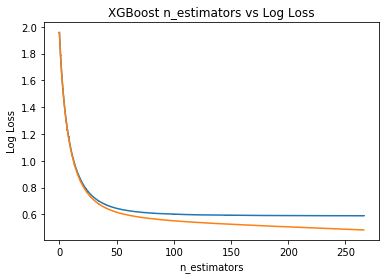

In [24]:
#以df的方式读取csv文件
cvresult = pd.DataFrame.from_csv('a_nestimators.csv')
        
#拿到测试集平均值
test_means = cvresult['test-mlogloss-mean']
#拿到测试集方差
test_stds = cvresult['test-mlogloss-std'] 
#拿到训练集的平均值
train_means = cvresult['train-mlogloss-mean']
#拿到训练集的方差
train_stds = cvresult['train-mlogloss-std'] 
#拿到数组
x_axis = range(0, cvresult.shape[0])
#画图        
pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
#x_axis  x轴
#test_means  y轴
#yerr=test_stds  曲线值
#label='Test   标签
pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
#x_axis  x轴
#test_means  y轴
#yerr=test_stds  曲线值
#label='Test   标签

#设置标题名
pyplot.title("XGBoost n_estimators vs Log Loss")
#设置x轴的名字
pyplot.xlabel( 'n_estimators' )
#设置y轴的名字
pyplot.ylabel( 'Log Loss' )
#保存为图片
pyplot.savefig( 'n_estimators4_1.png' )
#展示
pyplot.show()

由图可得  学习率为299